# Example: Develop a Multiclass Artificial Neural Network Image Classifier
This example will familiarize students with constructing, training, and testing a simple [Feed-Forward Artificial Neural Network](https://en.wikipedia.org/wiki/Feedforward_neural_network) that will classify images of handwritten numbers between `0,...,9` taken from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). Each digit between `0` and `9` has approximately 5000 example images, each of which is a `28`$\times$`28` grayscale image; thus, each image has `784` pixels.  

* In this example, we'll use the [Flux.jl package](https://github.com/FluxML/Flux.jl) to build, train, and test our image classifier. However, there are two excellent libraries for ANNs in Python (sort of), namely the [PyTorch library](https://pytorch.org/) from the [AI group at META](https://ai.meta.com/meta-ai/) and the [TensorFlow library](https://www.tensorflow.org/) developed by [Google](https://research.google/).

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [3]:
include("Include.jl")

In [4]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end];

## Prerequisites
Before training and testing the `ANN,` we need to construct two datasets. First, we need to build a `training dataset` of images that we will use to estimate the model parameters. We'll save training data in the `training_image_dataset` variable. Next, we'll construct a `test dataset,` which we'll use to see how well our `ANN` predicts data it has never seen. We'll save this data in the `testing_image_dataset` variable.
* Both the `training_image_dataset` and `testing_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`.
* The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of weird features. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

### Select a set of `training` images, and build the `training_image_dataset`
`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then convert these to a vector vector format.

In [7]:
number_of_training_examples = 3000;
number_digit_array = range(0,length=10,step=1) |> collect;
training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
for i ∈ number_digit_array
    
    # create a set for this digit -
    image_digit_array = Array{Gray{N0f8},3}(undef, 28, 28, number_of_training_examples);
    files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
    imagecount = 1;
    for fileindex ∈ 1:number_of_training_examples
        filename = files[fileindex];
        ext = file_extension(filename)
        if (ext == "jpg")
            image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
            imagecount += 1
        end
    end

    # capture -
    training_image_dictionary[i] = image_digit_array
end

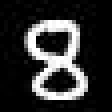

In [8]:
training_image_dictionary[8][:,:,10]

Next, we take the images and vectorize them. Each $N\times{N}$ image array is linearized, i.e., the $N\times{N}$ array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* __What's the deal with Float32__? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory space because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/) which has different memory constraints.

In [10]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, 28*28);
            linearindex = 1;
            for row ∈ 1:28
                for col ∈ 1:28
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

In [11]:
training_image_dataset[6000]

(Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bool[0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
onehot(5, number_digit_array)

10-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 1
 ⋅
 ⋅
 ⋅
 ⋅

### Select a set of `test` images, and build the `testing_image_dataset`
`Unhide` the code blocks below to see how we construct and populate the `testing_image_dataset` variable.

In [14]:
number_of_test_examples = 500;
testing_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
for i ∈ number_digit_array
    
    # create a set for this digit -
    image_digit_array = Array{Gray{N0f8},3}(undef, 28, 28, number_of_test_examples);
    files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
    imagecount = 1;
    for fileindex ∈ (number_of_training_examples + 1):(number_of_training_examples+number_of_test_examples)
        filename = files[fileindex];
        ext = file_extension(filename)
        if (ext == "jpg")
            image_digit_array[:,:,imagecount] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
            imagecount += 1
        end
    end

    # capture -
    testing_image_dictionary[i] = image_digit_array
end

In [15]:
testing_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
for i ∈ number_digit_array
    Y = onehot(i, number_digit_array);
    X = testing_image_dictionary[i];
    
    for t ∈ 1:number_of_test_examples
        D = Array{Float32,1}(undef, 28*28);
        linearindex = 1;
        for row ∈ 1:28
            for col ∈ 1:28
                D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                linearindex+=1;
            end
        end

        testing_tuple = (D,Y);
        push!(testing_image_dataset, testing_tuple);
    end
end

## Task 1: Setup the model structure and training
In this task, we'll construct a model and then train the model, i.e., learn the model parameters, using example images encoded in the the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. This is an example of _supervised batch learning_, i.e., the model learns its parameters on a fixed set of labeled examples. There is no update rule like an _online_ learning approach; new data cannot be easily included (once we have the parameters, we have them).

Let's start by getting the `number_of_input_states::Int64`, this will be the input dimension of the first layer in our model:

In [17]:
number_of_input_states = length(training_image_dataset[1][1])

784

Then, we build an empty model with default (random) parameter values but a fixed structure, i.e., the number and dimension of the layers, and the activation functions for each layer are specified when we build the model (but we'll update the parameters during training).
* We use [the Flux.jl machine learning library](https://github.com/FluxML/Flux.jl) to construct the neural network model. The model will have three layers: the input layer is a `784` $\times$ `512` layer with [relu activation functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), the hidden layer is a `512` $\times$ `10` layer and the output layer is the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [19]:
Flux.@layer MyFluxNeuralNetworkModel;
MyModel() = MyFluxNeuralNetworkModel(
    Chain(
        Dense(number_of_input_states, 512, relu),  
        Dense(512, 10, relu),
        NNlib.softmax)
);
model = MyModel().chain;

Next, specify the `loss` function that we will minimize to to esimate the model parameters. In this cross we choose a loss function that is appropriate for a multiclass classification problem, namely a [cross entropy loss function](https://en.wikipedia.org/wiki/Cross-entropy):

In [21]:
# setup a loss function -
loss(ŷ, y) = Flux.Losses.logitcrossentropy(ŷ, y; agg = mean); # loss for training multiclass classifiers

Then, let's specify which [Gradient descent method]() we will use to search parameter space and estimate the set of parameters that minimizes the `loss` function specified above. 
* In this case, we'll use [Gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) where the `λ` parameter denotes the `learning rate` and `β` denotes the momentum parameter. We save information about the optimizer in the `opt_state` variable, which will eventually get passed to the training method.

In [23]:
λ = 0.01; # learning rate
β = 0.90; # momentum parameter
opt_state = Flux.setup(Momentum(λ, β), model);

We are now ready to train the model. If the `should_we_train` flag is true, then we use the [Gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) to minimize a [cross entropy loss function](https://en.wikipedia.org/wiki/Cross-entropy). 
* Because of the error landscape's non-convex nature, we have to start from many different locations. We do `number_of_epochs` passes through the data, i.e., a forward pass for prediction and a backpropagation step for parameter updates.
* Training takes a long time. Thus, for each complete pass through the data, i.e., for each `epoch,` we save a `tmp` file holding the network state... just in case of `BOOOOOOOOM.`  

In [25]:
should_we_train = false; # set this flag to {true | false}
if (should_we_train == true)
    number_of_epochs = 250;
    for i = 1:number_of_epochs
        
        # train the model -
        Flux.train!(model, training_image_dataset, opt_state) do m, x, y
            loss(m(x), y)
        end
    
        # output some stuff -
        ridx = rand(1:number_of_training_examples);
        test_x, test_y = training_image_dataset[ridx][1], training_image_dataset[ridx][2];
        l = loss(model(test_x), test_y);
        println("Training example: $(ridx) has loss = $(l) in epoch $(i)");
    
        # save the state of the model, in case something happens. We can reload from this state
        jldsave("tmp-model-training-checkpoint.jld2", model_state = Flux.state(model))    
    end
else
    # if we don't train: load up a previous model
    model_state = JLD2.load("model-state-T3000-P500-E250-N512.jld2", "model_state");
    Flux.loadmodel!(model, model_state);
end

Chain(
  Dense(784 => 512, relu),              # 401_920 parameters
  Dense(512 => 10, relu),               # 5_130 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 407_050 parameters, 1.553 MiB.

## Task 2: How well does the model predict unseen versus observed images?
In this task, we'll check the generalization of the network, i.e., how well does it do on data it has not seen. One of the challenges with [Artifical Neural Networks (ANNs)](https://en.wikipedia.org/wiki/Neural_network_(machine_learning)) is the lack of generalizability, i.e., they _may not_ perform well on data the model has not seen. Let's explore this question:
* To begin with, let's compute the fraction of the `training data` that is not correctly classified. This will help us understand how many of the `N` training samples we get correct and how many we get wrong. We expect to be _mostly correct_ on this data.
* Next, we'll do the same thing but with the `test data,` i.e., data the model has never seen. We expect the correct prediction fraction to be less than the equivalent training value on the `test data`. 

### Compute the correct prediction fraction for the `training` and `test` datasets
Process each image in the `testing_image_dataset` dataset. Pass the pixel data from the image into the `model` instance, compute the predicted label `ŷ,` and compare the predicted and actual labels. If they argree, we update the `S` variable (a running count of the number of correct predictions)

In [28]:
S_training = 0;
for i ∈ eachindex(training_image_dataset)
    
    x = training_image_dataset[i][1];
    y = training_image_dataset[i][2];
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z,number_digit_array)
    y == ŷ ? S_training +=1 : nothing
end
correct_prediction_training = (S_training/length(training_image_dataset))*100;
println("Correct prediction % on the training data: $(correct_prediction_training)%");

Correct prediction % on the training data: 89.92999999999999%


In [29]:
S_testing = 0;
for i ∈ eachindex(testing_image_dataset)
    
    x = testing_image_dataset[i][1];
    y = testing_image_dataset[i][2];
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z, number_digit_array)
    y == ŷ ? S_testing+=1 : nothing
end
correct_prediction_test = (S_testing/length(testing_image_dataset))*100;
println("Correct prediction on the test data: $(correct_prediction_test)%");

Correct prediction on the test data: 89.64%


#### Example
Let's do a few manual examples.

In [31]:
let
    N = length(testing_image_dataset);
    i = rand(1:N)
    x = testing_image_dataset[i][1];
    y = testing_image_dataset[i][2];
    ŷ = model(x);
    [y ŷ]
end

10×2 Matrix{Float32}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 1.0  1.0
 0.0  0.0
 0.0  0.0
 0.0  0.0